In [1]:
# load libraries
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import interact
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import skimage.exposure as exposure
from torch.utils.data import DataLoader
import shutil

In [2]:
if torch.cuda.is_available():
    print("cuda available")    
    device = torch.device("cuda")
else:
    print("not available")
    device = torch.device("cpu")

cuda available


## Vizualisation 

In [4]:
img_vol = nib.load("data/train/volume/LUNG1-001_vol.nii.gz").get_fdata()
img_seg = nib.load("data/train/seg/LUNG1-001_seg.nii.gz").get_fdata()
img_lung = nib.load("data/train/lungs_seg/LUNG1-001_lungseg.nii.gz").get_fdata()

In [5]:
img_lung.shape

(308, 221, 89)

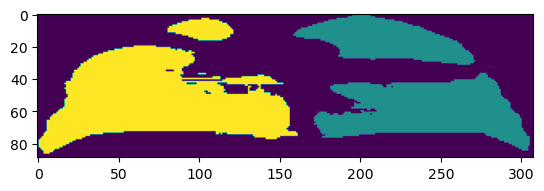

In [6]:
plt.imshow(img_lung[:,110,::-1].T)

In [7]:
i = 300

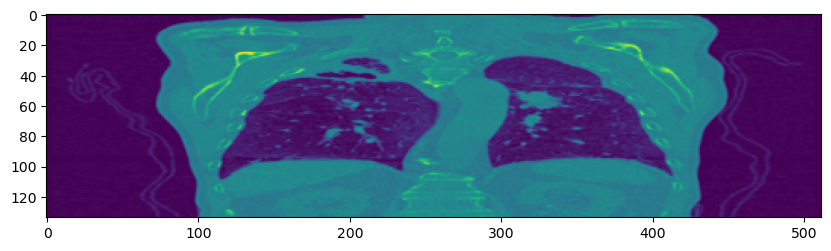

In [8]:
fig = plt.figure(figsize=(10, 6))
plt.imshow(img_vol[:,i,::-1].T)

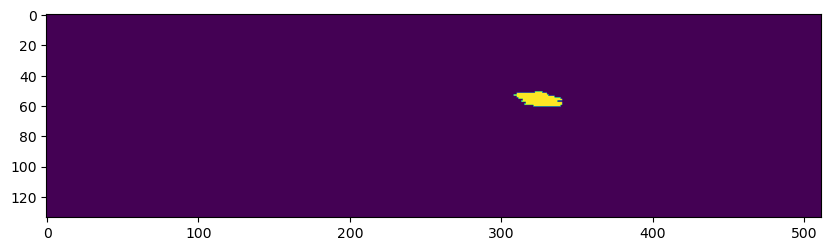

In [9]:
fig = plt.figure(figsize=(10, 6))
plt.imshow(img_seg[:,300,::-1].T)

In [198]:
def display_slice(slice) :
    return Image.fromarray(np.uint8(slice))

def display_ctscan(sequence) :
    def _show(frame=(0, sequence.shape[2]-1)) :
        return display_slice(sequence[:,frame,:])
    return interact(_show)
def get_images(idx) :
    if idx<10:
        img_vol = nib.load("data/train/volume/LUNG1-00"+str(idx)+"_vol.nii.gz").get_fdata()
        img_seg = nib.load("data/train/seg/LUNG1-00"+str(idx)+"_seg.nii.gz").get_fdata()
    if 10<=idx<100:
        img_vol = nib.load("data/train/volume/LUNG1-0"+str(idx)+"_vol.nii.gz").get_fdata()
        img_seg = nib.load("data/train/seg/LUNG1-0"+str(idx)+"_seg.nii.gz").get_fdata()
    return img_vol, img_seg

In [35]:
img_vol, img_seg = get_images(2)

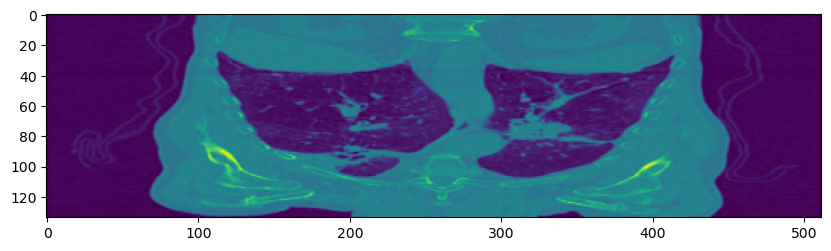

In [48]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_vol[:,290,:].T)

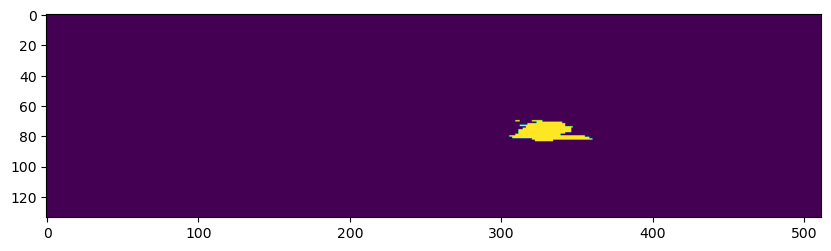

In [49]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_seg[:,290,:].T)

In [6]:
img_vol = nib.load("data/train/slice_vol/LUNG1-001_vol_slice_70.nii.gz").get_fdata()
img_seg = nib.load("data/train/slice_seg/LUNG1-001_seg_slice_70.nii.gz").get_fdata()

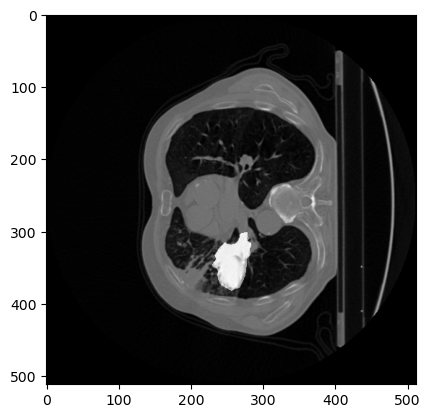

In [6]:
plt.imshow(img_vol+np.max(img_vol)*img_seg, cmap="gray")

In [6]:
def rescale_image(image, a=0, b=1/2):
    # image is the input image
    # a and b are the desired minimum and maximum values after rescaling
    min_val = np.min(image)
    max_val = np.max(image)

    # Rescale the image between a and b
    rescaled_image = a + ((image - min_val) * (b - a)) / (max_val - min_val)

    return rescaled_image

In [46]:
img_vol.max()

1206.000000453554

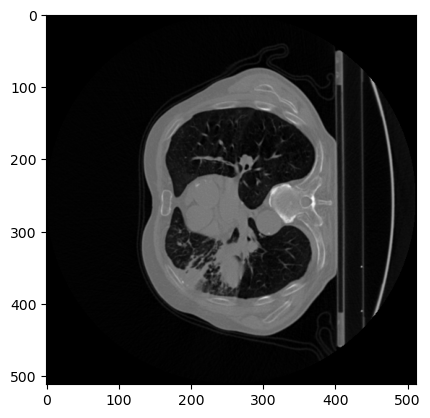

In [47]:
plt.imshow(rescale_image(img_vol), cmap="gray")

In [4]:
def display(img_vol, img_seg) :
    k, l, m = img_vol.shape
    img = np.zeros((k, 2*l, m))
    v_max = np.max(img_vol)
    img[:,:l,:] = v_max*img_seg
    img[:,l:,:] = img_vol
    display_ctscan(img)

In [5]:
print(np.shape(img_vol))

NameError: name 'img_vol' is not defined

In [10]:
def extract_slices(volume_data, slice_size):
    slices = []
    depth = volume_data.shape[2]

    for i in range(0, depth):
        slice_2d = volume_data[:, :, i]
        slices.append(slice_2d)

    return slices

In [224]:
slice_dir = "data/train/slice_vol/"
liste_vol = os.listdir(slice_dir) 
liste_vol.sort()
seg_dir = "data/train/slice_seg/"
liste_seg = os.listdir(seg_dir) 
liste_seg.sort()

In [422]:
xtraindir = "data/train/Xtrain"
ytraindir = "data/train/ytrain/"

In [423]:
os.listdir(xtraindir)

['LUNG1-206_vol_slice_26.nii.gz',
 'LUNG1-154_vol_slice_50.nii.gz',
 'LUNG1-193_vol_slice_61.nii.gz',
 'LUNG1-114_vol_slice_107.nii.gz',
 'LUNG1-019_vol_slice_60.nii.gz',
 'LUNG1-221_vol_slice_78.nii.gz',
 'LUNG1-234_vol_slice_45.nii.gz',
 'LUNG1-283_vol_slice_85.nii.gz',
 'LUNG1-010_vol_slice_4.nii.gz',
 'LUNG1-001_vol_slice_19.nii.gz',
 'LUNG1-130_vol_slice_96.nii.gz',
 'LUNG1-140_vol_slice_67.nii.gz',
 'LUNG1-236_vol_slice_122.nii.gz',
 'LUNG1-250_vol_slice_83.nii.gz',
 'LUNG1-170_vol_slice_70.nii.gz',
 'LUNG1-100_vol_slice_81.nii.gz',
 'LUNG1-016_vol_slice_50.nii.gz',
 'LUNG1-025_vol_slice_39.nii.gz',
 'LUNG1-164_vol_slice_47.nii.gz',
 'LUNG1-002_vol_slice_67.nii.gz',
 'LUNG1-168_vol_slice_5.nii.gz',
 'LUNG1-121_vol_slice_105.nii.gz',
 'LUNG1-072_vol_slice_96.nii.gz',
 'LUNG1-029_vol_slice_77.nii.gz',
 'LUNG1-048_vol_slice_53.nii.gz',
 'LUNG1-265_vol_slice_76.nii.gz',
 'LUNG1-185_vol_slice_102.nii.gz',
 'LUNG1-096_vol_slice_11.nii.gz',
 'LUNG1-049_vol_slice_59.nii.gz',
 'LUNG1-077_

In [ ]:
for i, (x, y) in enumerate(zip(xtraindir, ytraindir)):
    ytrain = nib.load(ytraindir+y).get_fdata()
    xtrain = nib.load(xtraindir+x).get_fdata()
    
    ytrainrot = np.rot90(ytrain)
    xtrainrot = np.rot90(xtrain)
    
    ytrainrot = nib.Nifti1Image(ytrainrot, img.affine)
    xtrainrot = nib.Nifti1Image(xtrainrot, img.affine)
    nib.save(xtrainrot, xtraindir+x[:-7]+"rot90"+x[-7:])
    nib.save(xtrainrot, ytraindir+y[:-7]+"rot90"+y[-7:])

In [216]:
#os.mkdir("data/train/Xtrain")
#os.mkdir("data/train/ytrain")

In [193]:
len(os.listdir("data/train/slice_vol/"))

34945

In [188]:
x

'LUNG1-001_vol_slice_1.nii.gz'

In [225]:
for i, (x, y) in enumerate(zip(liste_vol, liste_seg)):
    t = nib.load(seg_dir+y).get_fdata()
    if len(np.unique(t))>1:
        shutil.copy(slice_dir+x, "data/train/Xtrain/"+x)
        shutil.copy(seg_dir+y, "data/train/ytrain/"+y)
    else : 
        u = np.random.uniform(0, 1)
        if u<=.5 :
            shutil.copy(slice_dir+x, "data/train/Xtrain/"+x)
            shutil.copy(seg_dir+y, "data/train/ytrain/"+y)

In [181]:
y

'LUNG1-001_seg_slice_1.nii.gz'

## Dataset

In [10]:
def rescale_image(image, a=0, b=1):
    # image is the input image
    # a and b are the desired minimum and maximum values after rescaling
    min_val = np.min(image)
    max_val = np.max(image)

    # Rescale the image between a and b
    rescaled_image = a + ((image - min_val) * (b - a)) / (max_val - min_val)

    return rescaled_image

In [11]:
class IPPMedDataset(Dataset):
    def __init__(self, root_dir, transform=rescale_image):
        self.root_dir = root_dir
        vol_dir = os.path.join(root_dir, 'slice_vol')
        self.vol_paths = [os.path.join(vol_dir, vol_path) for vol_path in os.listdir(vol_dir)]        
        seg_dir = os.path.join(root_dir, 'slice_seg')
        self.seg_paths = [os.path.join(seg_dir, seg_path) for seg_path in os.listdir(seg_dir)]        
        self.vol_paths.sort()
        self.seg_paths.sort()
        self.transform = transform
        
    def __len__(self):
        return len(self.vol_paths)

    def __getitem__(self, idx):
        vol_path = self.vol_paths[idx]
        seg_path = self.seg_paths[idx]
        vol_img= nib.load(vol_path).get_fdata()
        seg_img = nib.load(seg_path).get_fdata()
        if self.transform:
            vol_img = self.transform(vol_img)
            #seg_img = self.transform(seg_img)
        return torch.from_numpy(vol_img).to(torch.float32).unsqueeze(0), \
               torch.from_numpy(seg_img).to(torch.float32).unsqueeze(0)

In [12]:
batch_size=1
data_root = "data/train/"
ippmed_dataset = IPPMedDataset(data_root)
data_train_loader = DataLoader(dataset=ippmed_dataset, batch_size=batch_size, shuffle=True) 

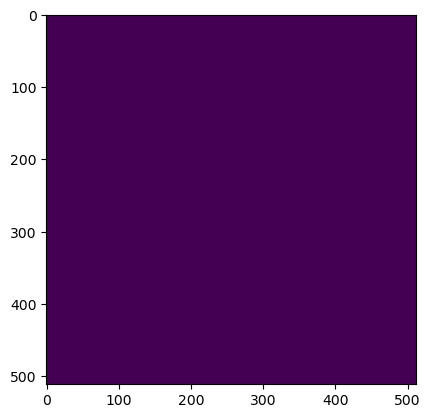

In [13]:
img_vol, img_seg = next(iter(data_train_loader))

plt.imshow(img_seg.squeeze(0, 1))

In [14]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        vol_dir = os.path.join(root_dir, 'volume')
        self.vol_paths = [os.path.join(vol_dir, vol_path) for vol_path in os.listdir(vol_dir)]        
        self.vol_paths.sort()
        self.transform = transform
        
    def __len__(self):
        return len(self.vol_paths)

    def __getitem__(self, idx):
        vol_path = self.vol_paths[idx]
        vol_img= nib.load(vol_path).get_fdata()

        if self.transform:
            vol_img = self.transform(vol_img)

        return vol_img

In [15]:
batch_size=1
data_root = "data/train/"
ippmed_dataset = IPPMedDataset(data_root, transform=None)
data_train_loader = DataLoader(dataset=ippmed_dataset, batch_size=batch_size, shuffle=True) 

In [13]:
batch_size=1
test_root = "data/test"
test_dataset = TestDataset(test_root, transform=transform)
print(len(test_dataset))
data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) 

NameError: name 'transform' is not defined

In [14]:
img_vol, img_seg = next(iter(data_train_loader))

In [15]:
img_vol = next(iter(data_loader))

NameError: name 'data_loader' is not defined

In [16]:
img_vol.shape

torch.Size([1, 1, 512, 512])

## Definition of the losses

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

## The model

In [18]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ELU(inplace=True)

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    print("cuda available")    
    device = torch.device("cuda")
else:
    print("not available")
    device = torch.device("cpu")

cuda available


In [94]:
cat slurm-83960.out 

cuda available
tensor(1.)
checkpoint_unet2d_elu_lr=1e-4_rescale_t=0.5_adam_15_epochs_batch=16_reduce_scheduler.pth
Number of images : 880
epoch  0 epoch loss : 1.4490379345687954 running time : 1017.2225105762482
Loss decreased
epoch  1 epoch loss : 1.1235518572682683 running time : 1019.0792288780212
Loss decreased
epoch  2 epoch loss : 0.9195665682581338 running time : 1015.3427231311798
Loss decreased
epoch  3 epoch loss : 0.585687839392234 running time : 1013.4120018482208
Loss decreased
epoch  4 epoch loss : 0.4292522594163364 running time : 1015.2529947757721
Loss decreased
epoch  5 epoch loss : 0.40094588698649947 running time : 1016.2188732624054
Loss decreased
epoch  6 epoch loss : 0.37290587496351113 running time : 1015.6953685283661
Loss decreased
epoch  7 epoch loss : 0.36493877154690296 running time : 1014.7621519565582
Loss decreased
epoch  8 epoch loss : 0.3431145738471638 running time : 1014.4765923023224
Loss decreased
epoch  9 epoch loss : 0.3278054261495444 running t

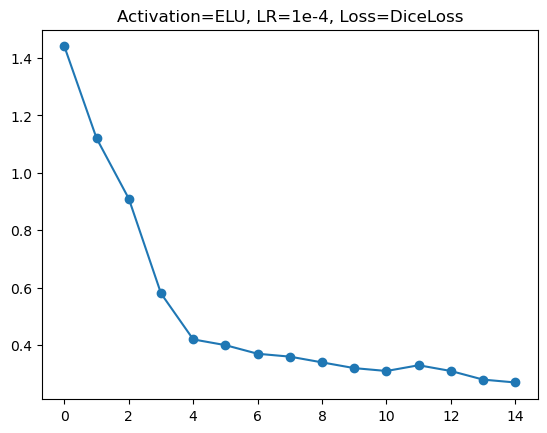

In [95]:
losses = [1.44, 1.12, 0.91, 0.58, 0.42, 0.4, 0.37, 0.36, 0.34, 0.32, 0.31, 0.33, 0.31 ,0.28, 0.27]
plt.plot(losses, marker='o')
plt.title("Activation=ELU, LR=1e-4, Loss=DiceLoss")
plt.show()

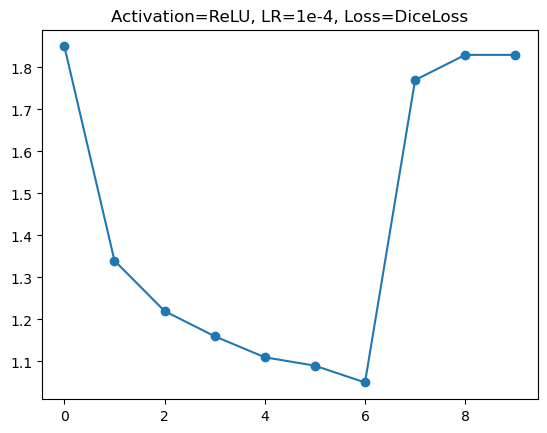

In [15]:
losses = np.array([1.85, 1.34, 1.22, 1.16, 1.11, 1.09, 1.05, 1.77, 1.83, 1.83])
plt.plot(losses, marker='o')
plt.title("Activation=ReLU, LR=1e-4, Loss=DiceLoss")
plt.show()

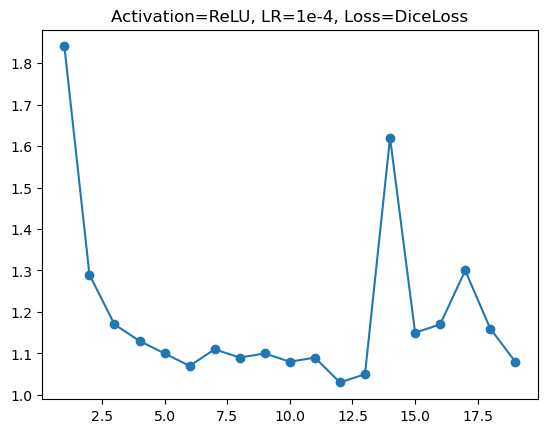

In [118]:
losses = np.array([1.84, 1.29, 1.17, 1.13, 1.10, 1.07, 1.11, 1.09, 1.10, 1.08, 1.09,  1.03, 1.05,
                  1.62, 1.15, 1.17, 1.30, 1.16, 1.08])
epochs = np.arange(1, 20)
plt.plot(epochs, losses, marker='o')
plt.title("Activation=ReLU, LR=1e-4, Loss=DiceLoss")
plt.show()

In [217]:
model = UNet()
model = model.to(device)
model.load_state_dict(torch.load("checkpoint_unet2d_elu_lr=1e-4_rescale_t=0.5_adam_20_epochs_batch=16_reduce_scheduler.pth", map_location=device))

<All keys matched successfully>

In [69]:
#### lr=1e-4, t=0.5, rescale, adam très prometteur !!

In [70]:
from time import time

In [71]:
img_v = nib.load("data/train/volume/LUNG1-002_vol.nii.gz").get_fdata()
img_s = nib.load("data/train/seg/LUNG1-002_seg.nii.gz").get_fdata()

In [123]:
img_v = nib.load("data/test/volume/LUNG1-001_vol.nii.gz").get_fdata()
#img_s = nib.load("data/train/seg/LUNG1-002_seg.nii.gz").get_fdata()

In [124]:
np.max(img_v)

3070.000029563904

In [125]:
img_vol = torch.from_numpy(img_v).to(torch.float32).unsqueeze(0).to(device)
img_seg = torch.from_numpy(img_s).to(torch.float32).unsqueeze(0).to(device)

In [126]:
img_vol.shape

torch.Size([1, 512, 512, 129])

In [127]:
img_vol[:,:256,:256,:50].shape

torch.Size([1, 256, 256, 50])

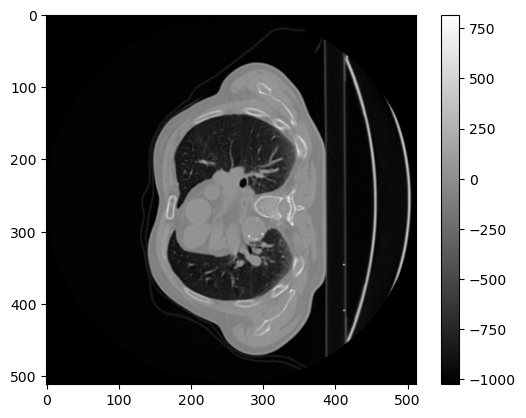

In [181]:
idx=60
plt.imshow((img_v[:,:,idx]), cmap="gray")
plt.colorbar()
plt.show()

In [182]:
img_vol = torch.from_numpy(img_v).to(torch.float32).unsqueeze(0).to(device)
#img_seg = torch.from_numpy(img_s).to(torch.float32).unsqueeze(0).to(device)
img_vol = img_vol[:,:,:,:].unsqueeze(0)
img_vol.shape

torch.Size([1, 1, 512, 512, 129])

In [183]:
img_vol.max()

tensor(3070., device='cuda:0')

In [184]:
test = img_vol[:,:,:,:,idx]
test.shape

torch.Size([1, 1, 512, 512])

In [185]:
test.max()

tensor(817.0037, device='cuda:0')

In [186]:
pred = model(test)

In [187]:
pred.max()

tensor(2.3120, device='cuda:0', grad_fn=<MaxBackward1>)

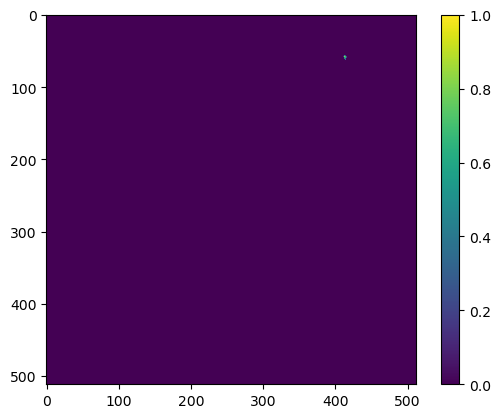

In [188]:
plt.imshow((torch.sigmoid(pred).squeeze(0, 1).cpu().detach().numpy()>.5))
plt.colorbar()
plt.show()

In [207]:
def display_slice(slice) :
    return Image.fromarray(np.uint8(slice))

def display_ctscan(sequence) :
    def _show(frame=(0, sequence.shape[-1]-1)) :
        return display_slice(sequence[:,:,frame])
    return interact(_show)

In [192]:
def prediction(img_v) :
    torch.from_numpy(img_v).to(torch.float32).unsqueeze(0).to(device)
    img_vol = torch.from_numpy(img_v).to(torch.float32).unsqueeze(0).to(device)
    img_vol = img_vol[:,:,:,:].unsqueeze(0)
    _, _, _, _, w = img_vol.shape
    predict = np.zeros((512, 512, w))
    for idx in range(w) :
        x = img_vol[:,:,:,:,idx]
        pred = model(x)
        predict[:,:,idx] = (torch.sigmoid(pred).squeeze(0, 1).cpu().detach().numpy()>.5)
    return predict

In [218]:
img_v = nib.load("data/test/volume/LUNG1-001_vol.nii.gz").get_fdata()
img_v = nib.load("data/train/volume/LUNG1-001_vol.nii.gz").get_fdata()

In [219]:
pred = prediction(img_v)

In [220]:
pred.shape

(512, 512, 134)

In [221]:
np.max(pred)

1.0

In [222]:
display_ctscan(1000*pred)

interactive(children=(IntSlider(value=66, description='frame', max=133), Output()), _dom_classes=('widget-inte…

<function __main__.display_ctscan.<locals>._show(frame=(0, 133))>